## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# This example imports functions from the DemoReadSGLXData module to read
# digital data. The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq digital channels.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
from scipy import stats
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter, welch
from scipy.stats import linregress, spearmanr, kendalltau, pearsonr, circstd
from statsmodels.stats.multitest import multipletests
import scipy.stats as sstat

from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from datetime import datetime
from scipy.io import savemat, loadmat
from sklearn.manifold import Isomap
import itertools
import mat73

from matplotlib_venn import venn2, venn3
# load pickle module
import dill as pickle
import time, os, math, sys
from joblib import Parallel, delayed
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

# for publication quality plots
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette('pastel')
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()
sns.set_context('poster')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



In [2]:
good_rec_shanks = [ 'MC022_20220627', 'MC022_20220628', 'MC022_20220629', 'MC022_20220718',
                        'JA179_20220802', 'JA179_20220804', 'JA179_20220805',  
                        'JA180_20220809', 'JA180_20220810', 'JA180_20220811', 'JA180_20220819', 
                        'JA181_20220809', 'JA181_20220812', 'JA181_20220817', 
                        'JA178_20220818', 'JA178_20220819', 'JA178_20220823',
                        'MC038_20220829', 'MC038_20220830',
                        'JA178_20220906', 'JA178_20220907', 'JA178_20220908', 'JA178_20220909']

d_good_shanks = {
    'JA178_left': [2], 'JA178_right': [2], 
    'JA179_left': [2, 3],
    'JA180_left': [2, 3],
    'JA181_left': [3], 
    'MC022_left': [1, 2],
    'MC038_left': [3]
}

vis_rec_id = ['20220627_MC022_lADN_red_H2_VR1_TS7-HF',  '20220627_MC022_lADN_red_H2_VR1_TS7-VIS',
       '20220628_MC022_lADN_red_H2_VR1_TS6-HF', '20220628_MC022_lADN_red_H2_VR1_TS7-VIS',
       '20220629_MC022_lADN_red_H2_VR1_TS6-HF', '20220629_MC022_lADN_red_H2_VR1_TS6-VIS',
       '20220908_JA178_rADN_yel_H2_VR1_TS6-HF', '20220908_JA178_rADN_yel_H2_VR1_TS6-VIS',
       '20220909_JA178_rADN_yel_H2_VR1_TS6-HF', '20220909_JA178_rADN_yel_H2_VR1_TS6-VIS']

## Functions

In [4]:
def get_recinfo_fname(fn):
    
    dts = fn.split('_')[0]
    mouse_id = fn.split('_')[1]
    hem = fn.split('_')[2]
    hstripe = fn.split('_')[4]
    cond = fn.split('_')[6]
    rec_session = mouse_id + '_' + dts
    
    return dts, mouse_id, hem, hstripe, cond, rec_session

def smooth_interp_yaw(yaw, window_length = 11, polyorder = 1):
    yaw_rad = np.deg2rad(yaw)
    yaw_rad[~np.isnan(yaw_rad)] = np.unwrap(yaw_rad[~np.isnan(yaw_rad)])
    nans, nanx = nan_helper(yaw_rad)
    yaw_rad[nans] = np.interp(nanx(nans), nanx(~nans), yaw_rad[~nans])
    yaw_intrp = np.rad2deg(yaw_rad)
    yaw_sm = savgol_filter(yaw_intrp, window_length=window_length, polyorder=polyorder)
    yaw_sm = yaw_sm % 360
    return yaw_sm

def get_yaw_speed_rec(rec, d_data):
    """
    get behavior from dict
    smoothsed yaw in deg, speed in cm/s
    """
    if 'HF' in rec:
        yaw = d_data[rec]['unity']['head_dir'].values
        yaw_sm = smooth_interp_yaw(yaw, 31, 2)
        lin_speed = d_data[rec]['unity']['speed'].values*100
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
    elif 'L1' in rec or 'D1' in rec:
        # speed in cm/s
        yaw = d_data[rec]['unity']['hd'].values
        yaw_sm = smooth_interp_yaw(yaw, 31, 2)
        lin_speed = d_data[rec]['unity']['tail_speed'].values
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
    else:
        yaw_sm = d_data[rec]['unity']['RotY'].values
#         yaw_sm = smooth_interp_yaw(yaw_sm, 31, 2)
        lin_speed = d_data[rec]['unity']['speed'].values*100
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
        
    return yaw_sm, lin_speed_sm

In [3]:
def get_stat_run_epochs(speed, window_size = 25, speed_thr = 4):
    speed = abs(speed)
    speed = speed[:speed.size//window_size*window_size]
    speed_bin_mean = np.nanmean(speed.reshape(-1, window_size), 1)  
    speed_idx = np.concatenate([np.arange(pair[0]*window_size, pair[0]*window_size + window_size) for 
                            pair in enumerate(speed_bin_mean) if pair[1] > speed_thr])[:-10]
    stat_idx = np.concatenate([np.arange(pair[0]*window_size, pair[0]*window_size + window_size) for 
                            pair in enumerate(speed_bin_mean) if pair[1] <= speed_thr])[:-10]
    return stat_idx, speed_idx




In [5]:
def adjust_offset_emb(y, dec):
    yerr = ((y[:] - dec[:]) + 180)%360 - 180
    offset = np.mean((yerr))
    # adjust offset
    dec = (dec + offset) % 360 
    return dec

def decode_az_isomap(x, y, yaw):
    dec_err = 0
    yaw_dec = 0
    yaw_dec_xy = np.arctan2(x, y)*180/np.pi
    yaw_dec_yx = np.arctan2(y, x)*180/np.pi
        
    yaw_dec_xy1 = yaw_dec_xy + 180
    yaw_dec_yx1 = yaw_dec_yx + 180
    
    yaw_dec_xy2 = yaw_dec_xy
    yaw_dec_xy2[yaw_dec_xy2 < 0] = yaw_dec_xy2[yaw_dec_xy2 < 0] + 360
    
    yaw_dec_yx2 = yaw_dec_yx
    yaw_dec_yx2[yaw_dec_yx2 < 0] = yaw_dec_yx2[yaw_dec_yx2 < 0] + 360
    
    yaw_dec_xy1 = adjust_offset_emb(yaw, yaw_dec_xy1)
    yaw_dec_xy2 = adjust_offset_emb(yaw, yaw_dec_xy2)
    yaw_dec_yx1 = adjust_offset_emb(yaw, yaw_dec_yx1)
    yaw_dec_yx2 = adjust_offset_emb(yaw, yaw_dec_yx2)
    
    dec_err1 = np.mean(abs(((yaw[:] - yaw_dec_xy1[:]) + 180)%360 - 180))
    dec_err2 = np.mean(abs(((yaw[:] - yaw_dec_xy2[:]) + 180)%360 - 180))
    dec_err3 = np.mean(abs(((yaw[:] - yaw_dec_yx1[:]) + 180)%360 - 180))
    dec_err4 = np.mean(abs(((yaw[:] - yaw_dec_yx2[:]) + 180)%360 - 180))
    
    dec_arr = np.array((dec_err1, dec_err2, dec_err3, dec_err4))
    idx = dec_arr.argmin()
    if idx == 0:
        yaw_dec = yaw_dec_xy1
    elif idx == 1:
        yaw_dec = yaw_dec_xy2
    elif idx == 2:
        yaw_dec = yaw_dec_yx1
    elif idx == 3:
        yaw_dec = yaw_dec_yx2
        
    return yaw_dec, dec_arr[idx], idx

In [6]:
def compute_ringness(inp):
 
    dist_tmp = []
    vis_dist = []
    x = inp[:,0]
    y = inp[:,1]
    n_samples10 = x.size//4
    centroid = np.mean(inp, axis = 0)
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    viscenter = (xmin + xmax)/2, (ymin + ymax)/2
    
    for idx in range(inp.shape[0]):
#         dist_tmp.append(math.dist(centroid[:],data[idx,:]))
        dist_tmp.append(np.linalg.norm(centroid-inp[idx, :])) 
        vis_dist.append(np.linalg.norm(viscenter-inp[idx, :]))
        
#     dist_tmp.sort(reverse = True)
    vis_dist_out = vis_dist.copy()
    vis_dist.sort()
    bot10 = vis_dist[:n_samples10]
    vis_dist.sort(reverse = True)
    top10 = vis_dist[:n_samples10]
    
    radius = np.mean(dist_tmp[:])
    vis_radius = np.mean(vis_dist[:])
    ringness = np.mean(bot10)/np.mean(top10)*radius
#     for idx in range(data.shape[0]):
#         ringness.append(np.abs(np.sqrt((data[idx,0]-centroid[0])**2+(data[idx,1]-centroid[1])**2)-radius))
    
    return radius, centroid, ringness, vis_dist_out

def compute_radius(x, y):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    viscenter = (xmin + xmax)/2, (ymin + ymax)/2
    
    vis_r = np.sqrt((x - viscenter[0])**2 + (y - viscenter[1])**2)
    r = np.sqrt(x**2 + y**2)
    return r, vis_r

In [7]:
def compute_betti(isomap_emb):
    H1_rates = isomap_emb
    
    if len(H1_rates) > 10000:
        idx = np.random.choice(np.arange(len(H1_rates)), 10000, replace=False)
        H1_rates = H1_rates[idx]
        
    barcodes = tda(H1_rates, maxdim=1, coeff=2)['dgms']
    h0 = barcodes[0]
    h1 = barcodes[1]

    # H2. Need to subsample points for computational tractability if 
    # number of points is large (can go higher but very slow)
    if len(H1_rates) > 1500:
        idx = np.random.choice(np.arange(len(H1_rates)), 1500, replace=False)
        H2_rates = H1_rates[idx]
    else:
        H2_rates = H1_rates
    barcodes = tda(H2_rates, maxdim=2, coeff=2)['dgms']
    h2 = barcodes[2]
    return h0, h1, h2

def get_long_bettibars(h0, h1, h2):
    h0[~np.isfinite(h0)] = 40
    plot_prcnt = [95, 90, 50] # order is h0, h1, h2
    to_plot = []
    for curr_h, cutoff in zip([h0, h1, h2], plot_prcnt):
#         print(curr_h.shape)
        top_indices  = np.argsort(curr_h[:, 1] - curr_h[:, 0])[-20:]
#         if curr_h.shape[0] < 100:
        plot_h = curr_h
#         else:
#             bar_lens = curr_h[:,1] - curr_h[:,0]
#             plot_h = curr_h[bar_lens > np.percentile(bar_lens, cutoff)]
        if cutoff == plot_prcnt[1]: 
            long_bar = sorted(curr_h[:, 1] - curr_h[:, 0])[-1]
        to_plot.append(curr_h[top_indices])
        
    return to_plot, long_bar

In [8]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

a = np.array([0, 47, 48, 49, 50, 97, 98, 99])
b = consecutive(a)

def ang_diff(a1, a2):
    a1 = np.array(a1)
    a2 = np.array(a2)
    return 180 - abs(abs(a1 - a2) - 180)

ang_diff(300, 45)

def compute_dYaw(yaw):

    dYaw = np.gradient(yaw)            
    idx_pos = np.where((dYaw > 180))[0]
    idx_neg = np.where((dYaw < -180))[0]

    dYaw[idx_pos] = dYaw[idx_pos] - 360
    dYaw[idx_neg] = dYaw[idx_neg] + 360
    
#     deltaYaw_filt = savgol_filter(dYaw, window_length=11, polyorder=2)
    # max 250 deg/s
    dYaw[abs(dYaw) > 5] = 0

    return dYaw

## Load data

In [9]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/VR_processed_data/df_tau_corr5.pkl'

df_tau_corr5 = pd.read_pickle(path)
df_tau_corr5.head()

,pair,tau,pval,rec_session,cond,head_fix,rec_id,hdc_pair,speed_thr,run,abstau
0,"(1, 4)",0.653044,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,all,0.653044
0,"(1, 4)",0.680417,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,stat,0.680417
0,"(1, 4)",0.506986,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,run,0.506986
0,"(1, 7)",-0.333650,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,all,0.333650
0,"(1, 7)",-0.367457,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,stat,0.367457


In [69]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/VR_processed_data/d_emb5.p'
# with open(path, 'rb') as handle:
#     d_emb = pickle.load(handle)
d_emb = pd.read_pickle(path)
d_emb.keys()

dict_keys(['20220818_JA178_lADN_red_H2_R_D1', '20220818_JA178_lADN_red_H2_R_L1', '20220819_JA178_lADN_red_H2_R_D1', '20220819_JA178_lADN_red_H2_R_L1', '20220823_JA178_lADN_red_H2_R_D1', '20220823_JA178_lADN_red_H2_R_L1', '20220906_JA178_rADN_yel_H2_R_D1', '20220906_JA178_rADN_yel_H2_R_L1', '20220907_JA178_rADN_yel_H2_R_D1', '20220907_JA178_rADN_yel_H2_R_L1', '20220908_JA178_rADN_yel_H2_R_D1', '20220908_JA178_rADN_yel_H2_R_L1', '20220909_JA178_rADN_yel_H2_R_D1', '20220909_JA178_rADN_yel_H2_R_L1', '20220802_JA179_lADN_red_H2_VR1_D1', '20220802_JA179_lADN_red_H2_VR1_L1', '20220804_JA179_lADN_red_H2_VR1_D1', '20220804_JA179_lADN_red_H2_VR1_L1', '20220805_JA179_lADN_red_H2_VR1_D1', '20220805_JA179_lADN_red_H2_VR1_L1', '20220809_JA180_lADN_red_H2_VR1_D1', '20220809_JA180_lADN_red_H2_VR1_L1', '20220810_JA180_lADN_red_H2_VR1_D1', '20220810_JA180_lADN_red_H2_VR1_L1', '20220811_JA180_lADN_red_H2_VR1_D1', '20220811_JA180_lADN_red_H2_VR1_L1', '20220819_JA180_lADN_red_H2_R_D1', '20220819_JA180_lADN

## Fig 2B-D

In [24]:
df_tau_corr5.cond.unique()

array(['D1', 'L1', 'TS6-HF', 'TS7-HF'], dtype=object)

/var/folders/v_/w_hl5qyx6gddpt2_xpcbzbrm0000gn/T/ipykernel_18546/1213801904.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,


<Axes: xlabel='cond', ylabel='abstau'>

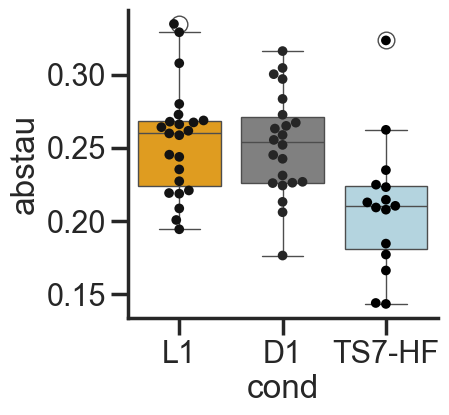

In [31]:
f, ax = plt.subplots(figsize = (4, 4))

y = 'abstau'
coi = ['L1', 'D1', 'TS7-HF']
pal = ['orange', 'gray', 'lightblue']

_inp_plot = df_tau_corr5[(df_tau_corr5.run == 'all') & (df_tau_corr5.cond.isin(coi))].groupby(['cond', 'rec_session']).mean(numeric_only = True).reset_index()
# _inp_plot2 = _inp_plot.pivot(index = ['rec_id', 'pair'], columns = 'run', values = 'tau').dropna().reset_index()
sns.swarmplot(data = _inp_plot, x = 'cond', y = y,  dodge = False, hue = 'cond', order = coi,
             size = 7, palette='dark:k', legend = None)

sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,
        palette=pal)

# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.savefig(f'box_{coi}_delta_{y}.pdf', transparent = True)  

In [33]:
(_inp_plot.groupby(['cond' ])[y].describe())

,count,mean,std,min,25%,50%,75%,max
cond,,,,,,,,
D1,22.0,0.252466,0.035106,0.176498,0.226371,0.253771,0.271303,0.316146
L1,23.0,0.254508,0.037078,0.194430,0.224111,0.259917,0.268340,0.334693
TS7-HF,15.0,0.209289,0.045554,0.143449,0.180907,0.210438,0.224060,0.323424


In [36]:
a1 = _inp_plot[(_inp_plot.cond == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.cond == coi[1])][y].values
c1 = _inp_plot[(_inp_plot.cond == coi[2])][y].values

stat, pval = stats.mannwhitneyu(a1, b1)
print(f'{coi[0]} vs {coi[1]} {stat} {pval}')

stat, pval = stats.mannwhitneyu(a1, c1)
print(f'{coi[0]} vs {coi[2]} {stat} {pval}')

stat, pval = stats.mannwhitneyu(b1, c1)
print(f'{coi[1]} vs {coi[2]} {stat} {pval}')

L1 vs D1 261.0 0.8647794336636582
L1 vs TS7-HF 278.0 0.0017142943773134408
D1 vs TS7-HF 267.0 0.0016903854925024758


### Compute delta tau across conditions

['L1', 'D1'] JA178_20220818
['L1', 'D1'] JA178_20220819
['L1', 'D1'] JA178_20220823
['L1', 'D1'] JA178_20220906
['L1', 'D1'] JA178_20220907
['L1', 'D1'] JA178_20220908
['L1', 'D1'] JA178_20220909
['L1', 'D1'] JA179_20220802
['L1', 'D1'] JA179_20220804
['L1', 'D1'] JA179_20220805
['L1', 'D1'] JA180_20220809
['L1', 'D1'] JA180_20220810
['L1', 'D1'] JA180_20220811
['L1', 'D1'] JA180_20220819
['L1', 'D1'] JA181_20220809
['L1', 'D1'] JA181_20220812
['L1', 'D1'] JA181_20220817
['L1', 'D1'] MC022_20220627


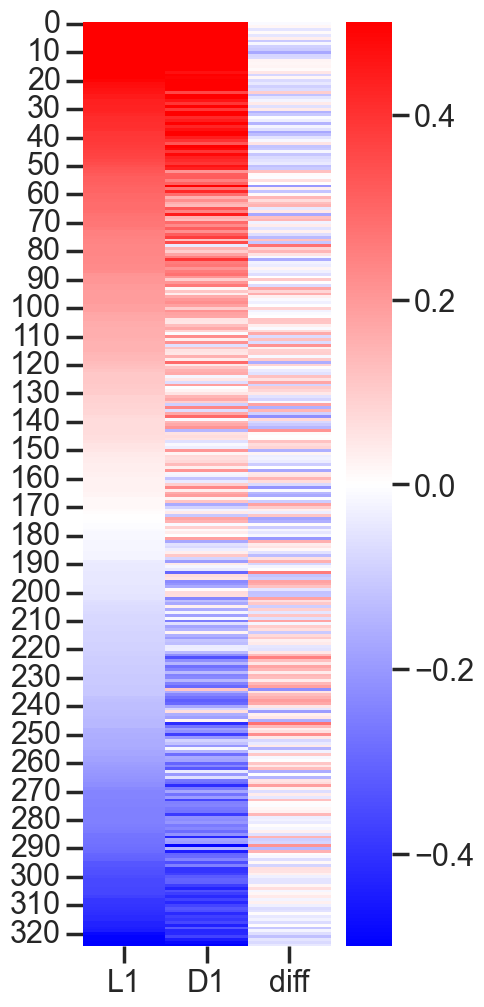

['L1', 'D1'] MC022_20220628
['L1', 'D1'] MC022_20220629
['L1', 'D1'] MC022_20220718
['L1', 'D1'] MC038_20220830
['L1', 'TS7-HF'] JA178_20220819
['L1', 'TS7-HF'] JA178_20220823
['L1', 'TS7-HF'] JA178_20220907
['L1', 'TS7-HF'] JA179_20220802
['L1', 'TS7-HF'] JA179_20220804
['L1', 'TS7-HF'] JA179_20220805
['L1', 'TS7-HF'] JA180_20220809
['L1', 'TS7-HF'] JA180_20220810
['L1', 'TS7-HF'] JA180_20220811
['L1', 'TS7-HF'] JA180_20220819
['L1', 'TS7-HF'] JA181_20220809
['L1', 'TS7-HF'] JA181_20220812
['L1', 'TS7-HF'] MC022_20220627


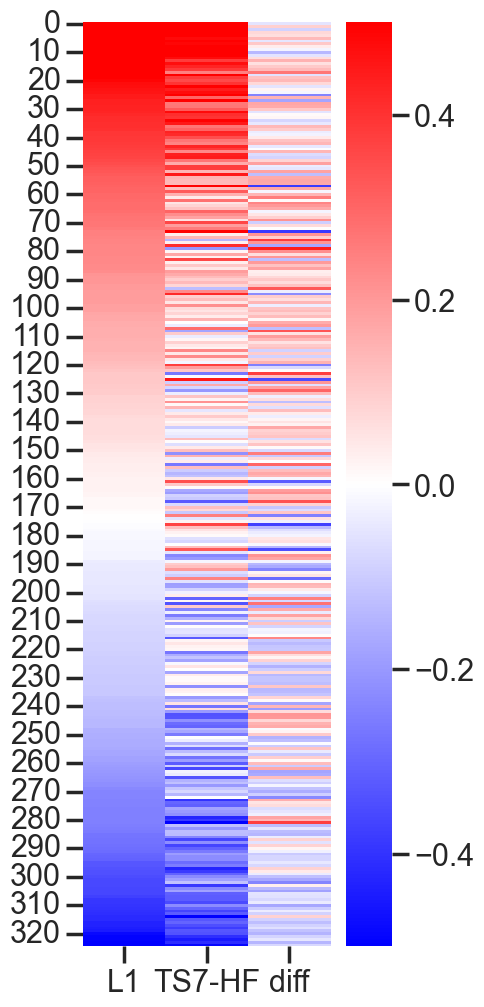

['L1', 'TS7-HF'] MC022_20220629
['L1', 'TS7-HF'] MC038_20220829


In [14]:
ls = []
cond_pairs = [['L1', 'D1'], ['L1', 'TS7-HF'], 
#               ['L1', 'TS6-MR'], ['L1', 'TS7-MR'], ['TS6-MR', 'TS7-MR'], ['TS6-HF', 'TS7-HF'], ['L1', 'TS6-HF'],  
             ]
pair_hdc = ['1_1', '1_0', '0_0']
for pt in pair_hdc:
    for cp in cond_pairs:
        coi = cp
        _inp_plot = df_tau_corr5[(df_tau_corr5.cond.isin(coi)) 
                                 & (df_tau_corr5.hdc_pair == pt) 
                                    & (df_tau_corr5.run == 'all') 
            ].pivot(index = ['rec_session', 'pair'], columns = 'cond', values = 'tau').reset_index().dropna()

        for recs in _inp_plot.rec_session.unique()[:]:
            print(cp, recs)
            tmp = _inp_plot[_inp_plot.rec_session == recs]
            tau_arr = tmp[coi].values
    #         gam = tmp['gam'].values
            sign_corr = (np.sign(tau_arr)[:, 0] * np.sign(tau_arr)[:, 1]) < 0

        #     idx_sort = np.argsort(tau_arr[:, 0])
            diff_tau = tau_arr[:, 0] - tau_arr[:, 1]
            pear_r, p_val = stats.pearsonr(tau_arr[:, 0], tau_arr[:, 1])
            strong_pairs = abs(diff_tau) > 0.1
            sign_sw = sign_corr & strong_pairs
            abs_tau = abs(diff_tau)
            ls.append(pd.DataFrame({'rec_session': recs, 'tau1': tau_arr[:, 0], 'tau2':tau_arr[:, 1], 'pair_hdc': pt,
                                    'pear_r': round(pear_r, 3), 'pear_pval': round(p_val, 3), 'n_pairs': tau_arr[:, 0].size, 
                  'diff_tau': diff_tau, 'abs_tau':abs_tau, 'cond': coi[0] + '_' + coi[1], 'sign_sw': sign_sw })) 
            # rep example
            if 'MC022_20220627' in recs:
                if tau_arr.shape[0] > 100:
                    f, ax = plt.subplots(figsize = (4, 12))
                else:
                    f, ax = plt.subplots(figsize = (4, 6))
    
                out = np.vstack((tau_arr.T, diff_tau))
                out_df = pd.DataFrame(out.T, columns = [coi[0], coi[1], 'diff'])
                out_df = out_df.sort_values(by = coi[0], ascending=False).reset_index(drop = True)
                sns.heatmap(out_df, cmap = 'bwr', vmin = -0.5, vmax = 0.5, yticklabels = 10)
    
                plt.show()
    #         plt.savefig(f'heatmap_nhdc_pearson_{cp}.pdf', transparent=True)
        
    
# df_delta_tau = pd.concat(ls)
# df_delta_tau.head()

/var/folders/v_/w_hl5qyx6gddpt2_xpcbzbrm0000gn/T/ipykernel_18546/1718464338.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,


<Axes: xlabel='cond', ylabel='abs_tau'>

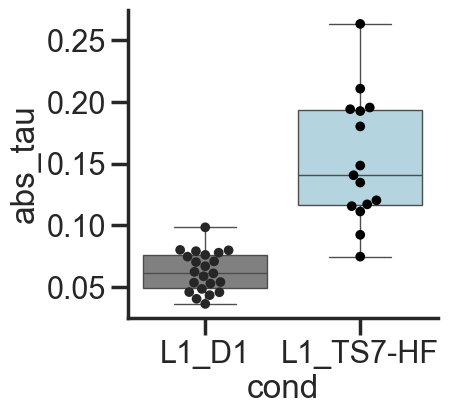

In [16]:
f, ax = plt.subplots(figsize = (4, 4))

y = 'abs_tau'
coi = ['L1_D1', 'L1_TS7-HF']
pal = ['gray', 'lightblue']

_inp_plot = df_delta_tau[(df_delta_tau.cond.isin(coi))].groupby(['cond', 'rec_session']).mean(numeric_only = True).reset_index()
# _inp_plot2 = _inp_plot.pivot(index = ['rec_id', 'pair'], columns = 'run', values = 'tau').dropna().reset_index()
sns.swarmplot(data = _inp_plot, x = 'cond', y = y,  dodge = False, hue = 'cond', order = coi,
             size = 7, palette='dark:k', legend = None)

sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,
        palette=pal)

# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.savefig(f'box_{coi}_delta_{y}.pdf', transparent = True)  

In [17]:
(_inp_plot.groupby(['cond' ])[y].describe())

,count,mean,std,min,25%,50%,75%,max
cond,,,,,,,,
L1_D1,22.0,0.062577,0.016096,0.036303,0.049562,0.061690,0.075714,0.098419
L1_TS7-HF,15.0,0.152793,0.051531,0.074647,0.116317,0.140657,0.193435,0.263335


In [18]:
a1 = _inp_plot[(_inp_plot.cond == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.cond == coi[1])][y].values

stat, pval = stats.mannwhitneyu(a1, b1)
print(f'{coi[0]} vs {coi[1]} {stat} {pval}')


L1_D1 vs L1_TS7-HF 7.0 1.1037925428060448e-06


## Fig 2E-F

### Plot HD ring manifold with betti bars: Arena vs VR

20220818_JA178_lADN_red_H2_R_L1
H1 bar length 35.00618243217468 dec err 38.42606530401068
off_manifold_index 0.0023655913978494624


<Figure size 1200x800 with 0 Axes>

20220819_JA178_lADN_red_H2_R_L1
H1 bar length 14.88380742073059 dec err 19.957841703007237
off_manifold_index 0.2806451612903226


<Figure size 1200x800 with 0 Axes>

20220823_JA178_lADN_red_H2_R_L1
H1 bar length 14.204681873321533 dec err 29.62543402441214
off_manifold_index 0.15806451612903225


<Figure size 1200x800 with 0 Axes>

20220906_JA178_rADN_yel_H2_R_L1
H1 bar length 6.518409729003906 dec err 26.36776020414956
off_manifold_index 0.3606451612903226


<Figure size 1200x800 with 0 Axes>

20220907_JA178_rADN_yel_H2_R_L1
H1 bar length 20.004520773887634 dec err 34.14669839638786
off_manifold_index 0.04709677419354839


<Figure size 1200x800 with 0 Axes>

20220908_JA178_rADN_yel_H2_R_L1
H1 bar length 17.163423538208008 dec err 25.97147821440301
off_manifold_index 0.08430107526881721


<Figure size 1200x800 with 0 Axes>

20220909_JA178_rADN_yel_H2_R_L1
H1 bar length 9.826086521148682 dec err 34.60357588108611
off_manifold_index 0.31483870967741934


<Figure size 1200x800 with 0 Axes>

20220802_JA179_lADN_red_H2_VR1_L1
H1 bar length 28.584116458892822 dec err 18.442068074222806
off_manifold_index 0.06946236559139785


<Figure size 1200x800 with 0 Axes>

20220804_JA179_lADN_red_H2_VR1_L1
H1 bar length 28.749816179275513 dec err 14.064488088997129
off_manifold_index 0.044516129032258066


<Figure size 1200x800 with 0 Axes>

20220805_JA179_lADN_red_H2_VR1_L1
H1 bar length 23.57874035835266 dec err 18.540524803176524
off_manifold_index 0.04064516129032258


<Figure size 1200x800 with 0 Axes>

20220809_JA180_lADN_red_H2_VR1_L1
H1 bar length 11.03909182548523 dec err 15.906263117202473
off_manifold_index 0.12322580645161291


<Figure size 1200x800 with 0 Axes>

20220810_JA180_lADN_red_H2_VR1_L1
H1 bar length 26.204941749572754 dec err 14.670316441150073
off_manifold_index 0.04150537634408602


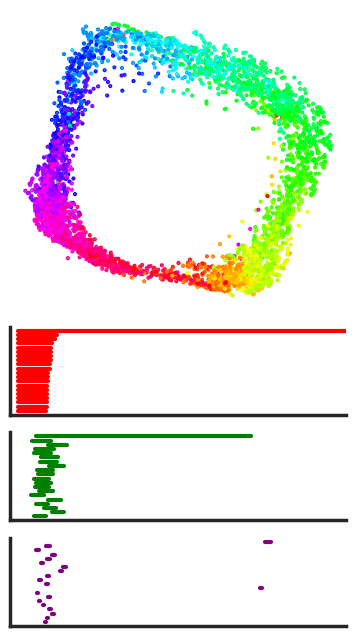

20220811_JA180_lADN_red_H2_VR1_L1
H1 bar length 32.469354033470154 dec err 18.227752558688127
off_manifold_index 0.03333333333333333


<Figure size 1200x800 with 0 Axes>

20220819_JA180_lADN_red_H2_R_L1
H1 bar length 29.73309326171875 dec err 24.79239422283911
off_manifold_index 0.023225806451612905


<Figure size 1200x800 with 0 Axes>

20220809_JA181_lADN_red_H2_VR1_L1
H1 bar length 15.231440544128418 dec err 21.163341097841958
off_manifold_index 0.09118279569892473


<Figure size 1200x800 with 0 Axes>

20220812_JA181_lADN_red_H2_VR1_L1
H1 bar length 15.604473114013672 dec err 20.16132771442514
off_manifold_index 0.2539784946236559


<Figure size 1200x800 with 0 Axes>

20220817_JA181_lADN_red_H2_R_L1
H1 bar length 6.464116454124451 dec err 33.822190732602856
off_manifold_index 0.6182795698924731


<Figure size 1200x800 with 0 Axes>

20220627_MC022_lADN_red_H2_R_L1
H1 bar length 21.347256183624268 dec err 20.134013074896924
off_manifold_index 0.14193548387096774


<Figure size 1200x800 with 0 Axes>

20220628_MC022_lADN_red_H2_R_L1
H1 bar length 18.989498376846313 dec err 17.173120226936863
off_manifold_index 0.12838709677419355


<Figure size 1200x800 with 0 Axes>

20220629_MC022_lADN_red_H2_R_L1
H1 bar length 24.011531591415405 dec err 13.16863252240393
off_manifold_index 0.024946236559139787


<Figure size 1200x800 with 0 Axes>

20220718_MC022_lADN_red_H2_VR1_L1
H1 bar length 38.44993281364441 dec err 20.53103113650673
off_manifold_index 0.023870967741935485


<Figure size 1200x800 with 0 Axes>

20220829_MC038_lADN_red_H2_R_L1
H1 bar length 29.683683156967163 dec err 18.79756898322346
off_manifold_index 0.010537634408602151


<Figure size 1200x800 with 0 Axes>

20220830_MC038_lADN_red_H2_R_L1
H1 bar length 32.450571060180664 dec err 32.71136359821722
off_manifold_index 0.0023655913978494624


<Figure size 1200x800 with 0 Axes>

20220819_JA178_lADN_red_H2_VR1_TS7-HF
H1 bar length 30.835001945495605 dec err 28.450719146859456
off_manifold_index 0.03570093457943925


<Figure size 1200x800 with 0 Axes>

20220823_JA178_lADN_red_H2_VR1_TS7-HF
H1 bar length 20.74352741241455 dec err 24.44355054925384
off_manifold_index 0.007450980392156863


<Figure size 1200x800 with 0 Axes>

20220907_JA178_rADN_yel_H2_VR1_TS7-HF
H1 bar length 17.75056529045105 dec err 34.419712229294404
off_manifold_index 0.16355140186915887


<Figure size 1200x800 with 0 Axes>

20220802_JA179_lADN_red_H2_VR1_TS7-HF
H1 bar length 40.648706674575806 dec err 24.722127285358074
off_manifold_index 0.2018181818181818


<Figure size 1200x800 with 0 Axes>

20220804_JA179_lADN_red_H2_VR1_TS7-HF
H1 bar length 20.077514171600342 dec err 35.773808148468206
off_manifold_index 0.39954545454545454


<Figure size 1200x800 with 0 Axes>

20220805_JA179_lADN_red_H2_VR1_TS7-HF
H1 bar length 10.340526342391968 dec err 43.27662609008659
off_manifold_index 0.661


<Figure size 1200x800 with 0 Axes>

20220809_JA180_lADN_red_H2_VR1_TS7-HF
H1 bar length 6.052234172821045 dec err 57.6480821936815
off_manifold_index 0.6682727272727272


<Figure size 1200x800 with 0 Axes>

20220810_JA180_lADN_red_H2_VR1_TS7-HF
H1 bar length 9.822737455368042 dec err 46.75713425988378
off_manifold_index 0.521090909090909


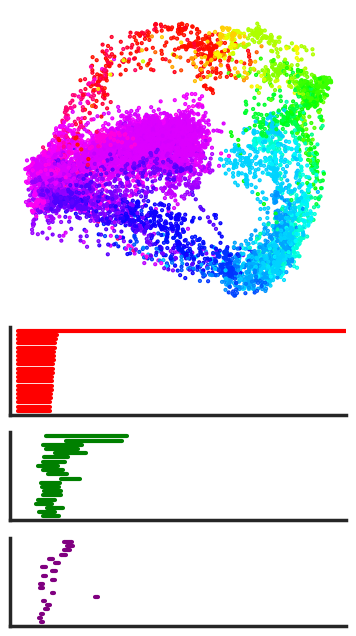

20220811_JA180_lADN_red_H2_VR1_TS7-HF
H1 bar length 17.70159339904785 dec err 58.99726190682763
off_manifold_index 0.5935454545454546


<Figure size 1200x800 with 0 Axes>

20220819_JA180_lADN_red_H2_VR1_TS7-HF
H1 bar length 35.793346643447876 dec err 15.85018338808432
off_manifold_index 0.03611111111111111


<Figure size 1200x800 with 0 Axes>

20220809_JA181_lADN_red_H2_VR1_TS7-HF
H1 bar length 3.9673826694488525 dec err 62.447518101226684
off_manifold_index 0.6609090909090909


<Figure size 1200x800 with 0 Axes>

20220812_JA181_lADN_red_H2_VR1_TS7-HF
H1 bar length 7.484193563461304 dec err 22.01428279276123
off_manifold_index 0.3412844036697248


<Figure size 1200x800 with 0 Axes>

20220627_MC022_lADN_red_H2_VR1_TS7-HF
H1 bar length 21.881947994232178 dec err 25.24410452014718
off_manifold_index 0.07043478260869565


<Figure size 1200x800 with 0 Axes>

20220629_MC022_lADN_red_H2_VR1_TS7-HF
H1 bar length 20.36861538887024 dec err 20.515868135020277
off_manifold_index 0.21875


<Figure size 1200x800 with 0 Axes>

20220829_MC038_lADN_red_H2_VR1_TS7-HF
H1 bar length 6.54386305809021 dec err 32.9536575615563
off_manifold_index 0.5296363636363637


<Figure size 1200x800 with 0 Axes>

,rec_id,cond,dts,mouse_id,epoch,h1_bar,dec_err,rec_session,paradigm,off_manifold_index
0,20220818_JA178_lADN_red_H2_R_L1,L1,20220818,JA178,full,35.006182,38.426065,JA178_20220818,L1,0.002366
0,20220819_JA178_lADN_red_H2_R_L1,L1,20220819,JA178,full,14.883807,19.957842,JA178_20220819,L1,0.280645
0,20220823_JA178_lADN_red_H2_R_L1,L1,20220823,JA178,full,14.204682,29.625434,JA178_20220823,L1,0.158065
0,20220906_JA178_rADN_yel_H2_R_L1,L1,20220906,JA178,full,6.518410,26.367760,JA178_20220906,L1,0.360645
0,20220907_JA178_rADN_yel_H2_R_L1,L1,20220907,JA178,full,20.004521,34.146698,JA178_20220907,L1,0.047097


In [38]:
col_list = ['red', 'green', 'purple']
coi = ['L1', 'TS7-HF']
angles = np.arange(0, 380, 20)
h1_bar_max = 40
ls = []

for k in d_emb.keys():
#     if k not in vis_rec_id:
#         continue
    dts, mouse_id, hem, hstripe, cond, rec_session = get_recinfo_fname(k)
    if cond not in coi:
        continue
    
    paradigm = cond.split('-')[-1]
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(6, 8)
    rec_session = mouse_id + '_' + dts
    if not rec_session in good_rec_shanks:
        continue
    tmp = d_emb[k]
    isomap = tmp['isomap']
    measured_yaw = tmp['measured_yaw']
    isomap_yaw, dec_err, _ = decode_az_isomap(isomap[:, 0], isomap[:, 1], measured_yaw[:])
    lin_speed = tmp['lin_vel']
    h1_bar = tmp['h1_bar']

    # compute off manifold ratios
    _, rad_manifold = compute_radius(isomap[:,0], isomap[:,1])

    r90  = np.percentile(rad_manifold, 90)
    threshold = (r90 - 0.3*r90)

    off_ring = rad_manifold < threshold
    off_ring_ratio = np.sum(off_ring)/rad_manifold.size
    h0 = tmp['h0']
    h1 = tmp['h1']
    h2 = tmp['h2']   

    print(f'{k}')
    print(f'H1 bar length {h1_bar} dec err {dec_err}')
    print(f'off_manifold_index {off_ring_ratio}')

    # rep example
    if 'JA180_20220810' in rec_session:
    
        ax = fig.add_subplot(gs[0:3, 0:3])
        ax.scatter(isomap[:,0], isomap[:,1], s = 1, c = measured_yaw[:], 
                                               vmin = 0, vmax = 360, cmap = 'hsv')
        ax.axis('off')
        # ax.set_xlim(-40, 40)
        # ax.set_ylim(-40, 40)
        plt.xticks([])
     
        to_plot, h1_bar_run = get_long_bettibars(h0, h1, h2)
        
        for curr_betti, curr_bar in enumerate(to_plot):
            ax = fig.add_subplot(gs[curr_betti +3: curr_betti + 4, :3])
            for i, interval in enumerate((curr_bar)):
                ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti], lw=3)
            ax.set_xlim([-1, 40])
            plt.xticks([])
            plt.yticks([])
        
    
    tmp_df = pd.DataFrame({'rec_id': k,  'cond': cond,  'dts': dts, 'mouse_id': mouse_id,
                       'epoch': 'full', 'h1_bar': h1_bar, 'dec_err': dec_err, 'rec_session':rec_session,
                         'paradigm':paradigm, 'off_manifold_index': off_ring_ratio}, index = [0])
    ls.append(tmp_df)    
    
    # break
    plt.show()
    
df_betti = pd.concat(ls)
df_betti.head()

/var/folders/v_/w_hl5qyx6gddpt2_xpcbzbrm0000gn/T/ipykernel_18546/2093118071.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = _inp_plot, x = 'paradigm', y = y, palette=pal)


<Axes: xlabel='paradigm', ylabel='off_manifold_index'>

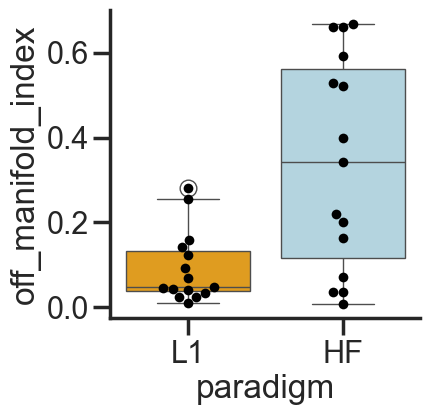

In [39]:
f, ax  = plt.subplots(figsize = (4, 4))
# make sure session has corresponding VR session
vr_sess = df_betti[df_betti.paradigm == 'HF'].rec_session.unique()
_inp_plot = df_betti[df_betti.rec_session.isin(vr_sess)]
y = 'off_manifold_index'
pal = ['orange', 'lightblue']
sns.boxplot(data = _inp_plot, x = 'paradigm', y = y, palette=pal)
sns.swarmplot(data = _inp_plot, x = 'paradigm', y = y, size = 7, 
              color = 'k', dodge = True, legend = False)

# plt.savefig(f'VR_boxplot_{y}_full.pdf', transparent = True)

In [40]:
_inp_plot.groupby('paradigm')[y].describe()

,count,mean,std,min,25%,50%,75%,max
paradigm,,,,,,,,
HF,15.0,0.340607,0.251211,0.007451,0.116993,0.341284,0.561591,0.668273
L1,15.0,0.092287,0.084061,0.010538,0.036989,0.047097,0.132581,0.280645


In [41]:
a1 = _inp_plot[(_inp_plot.paradigm == 'L1')][y].values
b1 = _inp_plot[(_inp_plot.paradigm == 'HF')][y].values

stat, pval = stats.mannwhitneyu(a1, b1)
print(f'{coi[0]} vs {coi[1]} {stat} {pval}')


L1 vs TS7-HF 49.0 0.00897202481281498


## Fig 3A: Plot HD ring manifold with betti bars: Arena vs VR - stat vs run

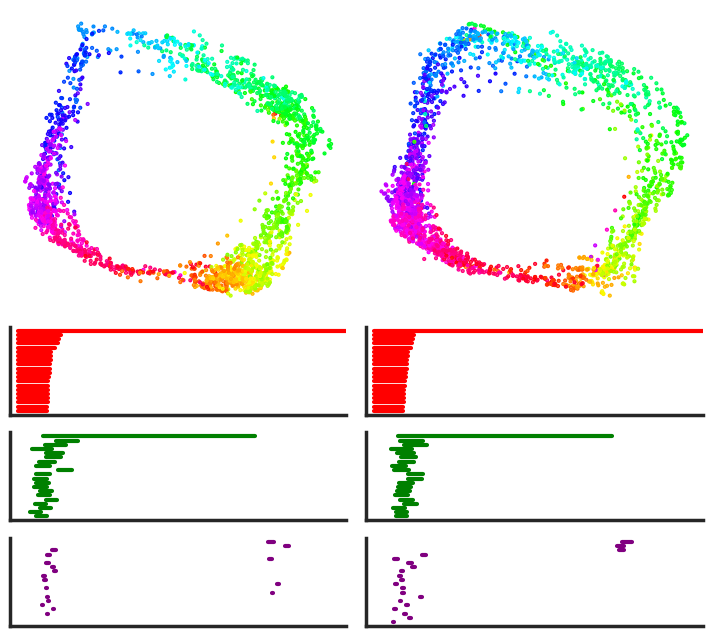

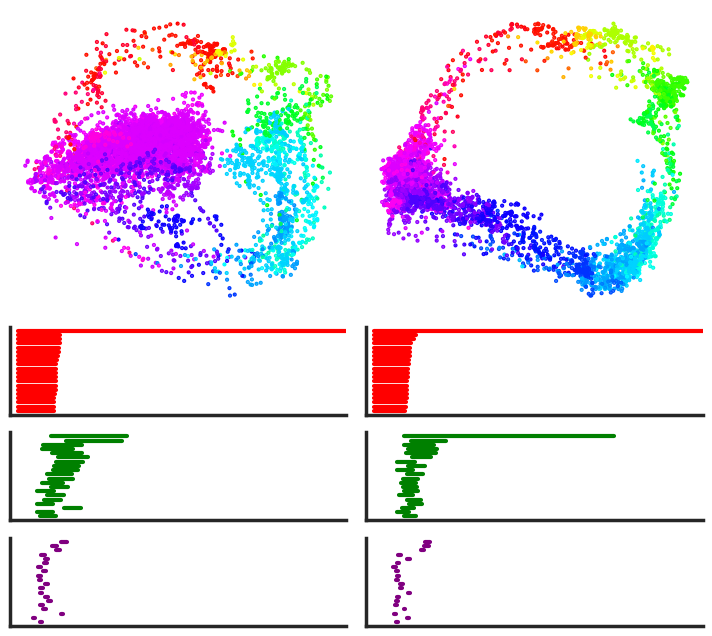

,rec_id,cond,dts,mouse_id,az_occ,run,h1_bar,dec_err,rec_session,stat_off_manifold,run_ratio,paradigm
0,20220818_JA178_lADN_red_H2_R_L1,L1,20220818,JA178,1.000000,stat,35.006182,38.426,JA178_20220818,0.149630,0.415054,L1
0,20220818_JA178_lADN_red_H2_R_L1,L1,20220818,JA178,1.000000,locom,33.840600,43.935,JA178_20220818,0.149630,0.415054,L1
0,20220819_JA178_lADN_red_H2_R_L1,L1,20220819,JA178,1.000000,stat,14.883807,19.958,JA178_20220819,0.280974,0.289247,L1
0,20220819_JA178_lADN_red_H2_R_L1,L1,20220819,JA178,1.000000,locom,14.734502,26.278,JA178_20220819,0.280974,0.289247,L1
0,20220823_JA178_lADN_red_H2_R_L1,L1,20220823,JA178,0.944444,stat,14.204682,29.625,JA178_20220823,0.225275,0.408602,L1


In [70]:
col_list = ['red', 'green', 'purple']
coi = ['L1', 'TS7-HF']
angles = np.arange(0, 380, 20)
h1_bar_max = 40
ls = []

for k in d_emb.keys():
    # if k not in vis_rec_id:
    #     continue
    dts, mouse_id, hem, hstripe, cond, rec_session = get_recinfo_fname(k)
    if cond not in coi:
        continue
    
    paradigm = cond.split('-')[-1]

    rec_session = mouse_id + '_' + dts
    
    tmp = d_emb[k]
    isomap = tmp['isomap']
    measured_yaw = tmp['measured_yaw']
    isomap_yaw, dec_err, _ = decode_az_isomap(isomap[:, 0], isomap[:, 1], measured_yaw[:])
    stat_idx, run_idx = tmp['stat_idx'], tmp['run_idx']
    stat_dec_err, loc_dec_err = tmp['stat']['dec_err'], tmp['run']['dec_err']
    stat_az_occ, run_az_occ = tmp['stat_az_occ'], tmp['run_az_occ']
    dec_err = round(np.mean(abs(((measured_yaw[:] - isomap_yaw[:]) + 180)%360 - 180)), 3)
    lin_speed = tmp['lin_vel']
    
    h1_bar = tmp['h1_bar']
    h1_bar_stat = tmp['stat']['h1_bar']
    h1_bar_run = tmp['run']['h1_bar']
    # print(f'stat:{h1_bar_stat}, run:{h1_bar_run}, all: {h1_bar}')
    run_ratio = run_idx.size/lin_speed.size
    # 50 samples = 5s
#     occup, _ = np.histogram(measured_yaw[stat_idx], bins = angles)
#     stat_az_occ = occup[occup > 10].size/occup.size
#     occup, _ = np.histogram(measured_yaw[run_idx], bins = angles)
#     run_az_occ = occup[occup > 10].size/occup.size
    # compute off manifold ratios
    _, rad_manifold = compute_radius(isomap[:,0], isomap[:,1])
    _, rad_manifold_stat = compute_radius(isomap[stat_idx,0], isomap[stat_idx,1])
    _, rad_manifold_loc = compute_radius(isomap[run_idx,0], isomap[run_idx,1])

    offmanifold_threshold = np.percentile(rad_manifold_loc, 10)
    stat_off_manifold = np.sum(rad_manifold_stat < offmanifold_threshold)/rad_manifold_stat.size

        # rep example
    if 'JA180_20220810' in rec_session:
        fig = plt.figure(figsize=(12, 8))
        gs = gridspec.GridSpec(6, 8)
        ax = fig.add_subplot(gs[0:3, 0:3])
        ax.scatter(isomap[stat_idx,0], isomap[stat_idx,1], s = 1, c = measured_yaw[stat_idx], 
                                               vmin = 0, vmax = 360, cmap = 'hsv')
        ax.axis('off')
        plt.xticks([])
        # ax.set_xlim(-40, 40)
        # ax.set_ylim(-40, 40)
        #         plt.yticks([])
        ax = fig.add_subplot(gs[0:3, 3:6])
        ax.scatter(isomap[run_idx,0], isomap[run_idx,1], s = 1, c = measured_yaw[run_idx], 
                                               vmin = 0, vmax = 360, cmap = 'hsv')
        ax.axis('off')
        plt.xticks([])
        # ax.set_xlim(-40, 40)
        # ax.set_ylim(-40, 40)
    
        h0 = tmp['h0']
        h1 = tmp['h1']
        h2 = tmp['h2']
        to_plot, h1_bar = get_long_bettibars(h0, h1, h2)
        
        h0 = tmp['stat']['h0']
        h1 = tmp['stat']['h1']
        h2 = tmp['stat']['h2']
        to_plot, h1_bar_stat = get_long_bettibars(h0, h1, h2)
    
        for curr_betti, curr_bar in enumerate(to_plot):
            ax = fig.add_subplot(gs[curr_betti +3: curr_betti + 4, :3])
            for i, interval in enumerate((curr_bar)):
                ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti], lw=3)
            ax.set_xlim([-1, 40])
            plt.xticks([])
            plt.yticks([])
    
        h0 = tmp['run']['h0']
        h1 = tmp['run']['h1']
        h2 = tmp['run']['h2']    
        to_plot, h1_bar_run = get_long_bettibars(h0, h1, h2)
        
        for curr_betti, curr_bar in enumerate(to_plot):
            ax = fig.add_subplot(gs[curr_betti +3: curr_betti + 4, 3:6])
            for i, interval in enumerate((curr_bar)):
                ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti], lw=3)
            ax.set_xlim([-1, 40])
            plt.xticks([])
            plt.yticks([])
        
    # print(f'{k}')
#     print(f'stat:{h1_bar_stat}, run:{h1_bar_run}, all: {h1_bar}')
    # print(f'dec err stat:{stat_dec_err}, run:{loc_dec_err}, all {dec_err}')
    
    
    plt.show()
    
#     break
    
    tmp_df = pd.DataFrame({'rec_id': k,  'cond': cond,  'dts': dts, 'mouse_id': mouse_id, 'az_occ':stat_az_occ,
                       'run': 'stat', 'h1_bar': h1_bar, 'dec_err': dec_err, 'rec_session':rec_session,
                        'stat_off_manifold': stat_off_manifold, 'run_ratio': run_ratio, 'paradigm':paradigm}, index = [0])
    ls.append(tmp_df)

    tmp_df = pd.DataFrame({'rec_id': k, 'cond': cond, 'dts': dts, 'mouse_id': mouse_id, 'az_occ':run_az_occ, 
                       'run': 'locom', 'h1_bar': h1_bar_run, 'dec_err': loc_dec_err, 'rec_session':rec_session,
                      'stat_off_manifold': stat_off_manifold, 'run_ratio': run_ratio, 'paradigm':paradigm}, index = [0])
    ls.append(tmp_df)
    
    
    # break
df_betti_run = pd.concat(ls)
df_betti_run.head()

## Fig 3B

<Axes: xlabel='cond', ylabel='h1_bar'>

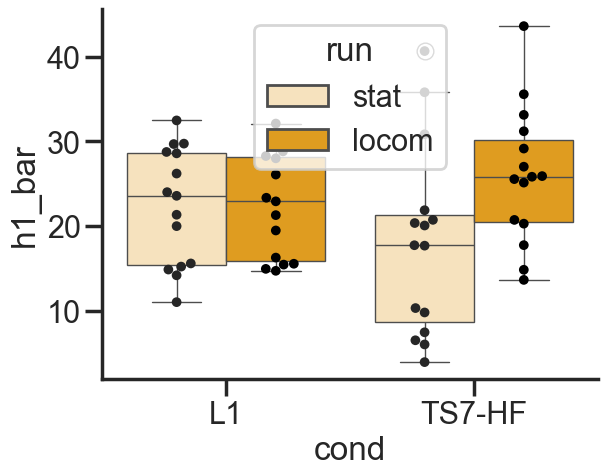

In [93]:
vr_sess = df_betti_run[df_betti_run.paradigm == 'HF'].rec_session.unique()
y = 'h1_bar'
pal = ['moccasin', 'orange',  ]
_inp_plot = df_betti_run[ (df_betti_run.rec_session.isin(vr_sess)) ]

sns.boxplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', 
            palette = pal)
sns.swarmplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', palette = 'dark:k', size = 7,
              dodge = True, legend = False)

# plt.savefig(f'box_run_betti_{coi}_{y}.pdf', transparent = True)  

In [94]:
_inp_plot.groupby(['cond', 'run'])[y].describe()

count       mean        std        min        25%        50%  \
cond   run                                                                   
L1     locom   15.0  22.447191   6.093341  14.734502  15.930371  22.927136   
       stat    15.0  22.355370   6.878312  11.039092  15.417957  23.578740   
TS7-HF locom   15.0  25.957281   7.994900  13.662973  20.515942  25.827250   
       stat    15.0  18.000784  11.129120   3.967383   8.653466  17.750565   

                    75%        max  
cond   run                          
L1     locom  28.134538  32.101129  
       stat   28.666966  32.469354  
TS7-HF locom  30.172547  43.590191  
       stat   21.312738  40.648707

In [95]:
a1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[0])][y].values
a2 = _inp_plot[(_inp_plot.run == 'locom') & (_inp_plot['cond'] == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[1])][y].values
b2 = _inp_plot[(_inp_plot.run == 'locom') & (_inp_plot['cond'] == coi[1])][y].values

stat1, pval1 = stats.wilcoxon(a1, a2)
print(f'{coi[0]} stat vs run {stat1} {pval1}')
stat2, pval2 = stats.wilcoxon(b1, b2)
print(f'{coi[1]} stat vs run {stat2} {pval2}')
stat3, pval3 = stats.mannwhitneyu(a1, b1)
print(f'stat  {stat3} {pval3}')
stat4, pval4 = stats.mannwhitneyu(a2, b2)
print(f'run {stat4} {pval4}')
pvals = [pval1, pval2, pval3, pval4]  
print('Benjamini/Hochberg (non-negative)')
print(multipletests(pvals, alpha=0.05, method='fdr_bh'))

L1 stat vs run 29.0 0.083251953125
TS7-HF stat vs run 7.0 0.00115966796875
stat  146.0 0.17106923105635186
run 89.0 0.3400858902842717
Benjamini/Hochberg (non-negative)
(array([False,  True, False, False]), array([0.16650391, 0.00463867, 0.22809231, 0.34008589]), np.float64(0.012741455098566168), 0.0125)


## Fig 3C: tau corr stat vs run

<Axes: xlabel='cond', ylabel='abstau'>

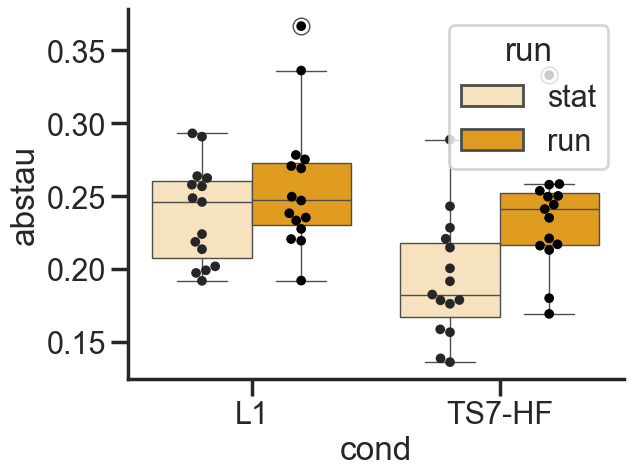

In [119]:
y = 'abstau'
pal = ['moccasin', 'orange']
_inp_plot = df_tau_corr5[(df_tau_corr5.cond.isin(coi)) 
                    & (df_tau_corr5.rec_session.isin(vr_sess))
                    & (df_tau_corr5.run != 'all')].groupby(['cond', 
                                                   'rec_id', 'run']).mean(numeric_only=True).reset_index()

sns.boxplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', hue_order = ['stat', 'run'],
            palette = pal)
sns.swarmplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', hue_order = ['stat', 'run'], 
              palette = 'dark:k', size = 7,
              dodge = True, legend = False)

# plt.savefig(f'box_run_betti_{coi}_{y}.pdf', transparent = True)  

In [120]:
_inp_plot.groupby(['cond', 'run'])['abstau'].describe()

count      mean       std       min       25%       50%  \
cond   run                                                             
L1     run    15.0  0.257410  0.045299  0.192253  0.230584  0.247152   
       stat   15.0  0.237860  0.033548  0.192060  0.207880  0.246145   
TS7-HF run    15.0  0.236100  0.038053  0.169415  0.216621  0.241274   
       stat   15.0  0.193082  0.041135  0.136337  0.167556  0.182657   

                  75%       max  
cond   run                       
L1     run   0.273075  0.366714  
       stat  0.260281  0.293208  
TS7-HF run   0.252047  0.333136  
       stat  0.217897  0.288886

In [121]:
a1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[0])][y].values
a2 = _inp_plot[(_inp_plot.run == 'run') & (_inp_plot['cond'] == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[1])][y].values
b2 = _inp_plot[(_inp_plot.run == 'run') & (_inp_plot['cond'] == coi[1])][y].values

stat1, pval1 = stats.wilcoxon(a1, a2)
print(f'{coi[0]} stat vs run {stat1} {pval1}')
stat2, pval2 = stats.wilcoxon(b1, b2)
print(f'{coi[1]} stat vs run {stat2} {pval2}')
stat3, pval3 = stats.mannwhitneyu(a1, b1)
print(f'stat  {stat3} {pval3}')
stat4, pval4 = stats.mannwhitneyu(a2, b2)
print(f'run {stat4} {pval4}')
pvals = [pval1, pval2, pval3, pval4]  
print('Benjamini/Hochberg (non-negative)')
print(multipletests(pvals, alpha=0.05, method='fdr_bh'))

L1 stat vs run 23.0 0.03533935546875
TS7-HF stat vs run 0.0 6.103515625e-05
stat  184.0 0.003230143595586664
run 143.0 0.21337370709311843
Benjamini/Hochberg (non-negative)
(array([ True,  True,  True, False]), array([0.04711914, 0.00024414, 0.00646029, 0.21337371]), np.float64(0.012741455098566168), 0.0125)


## Fig 3D: off-manifold index

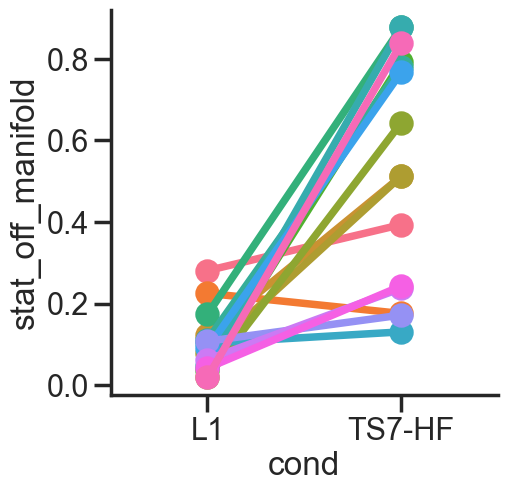

In [96]:
f, ax = plt.subplots(figsize = (5, 5))
y = 'stat_off_manifold'
coi = ['L1', 'TS7-HF']
_inp_plot = df_betti_run[df_betti_run.cond.isin(coi) 
                     & (df_betti_run.run == 'stat')
                     & (df_betti_run.rec_session.isin(vr_sess))
                    ]
sns.pointplot(data = _inp_plot, x = 'cond', y = y, hue = 'rec_session',
             order = coi)

# sns.barplot(data = _inp_plot, x = 'cond', y = y, errorbar= ('ci', 68), palette=pal)
# sns.swarmplot(data = _inp_plot, x = 'cond', y = y, color = 'k', size = 10)
plt.legend([],[], frameon=False)
# plt.savefig(f'point_{coi}_{y}.pdf', transparent = True) 

In [97]:
_inp_plot.groupby('cond')[y].describe()

,count,mean,std,min,25%,50%,75%,max
cond,,,,,,,,
L1,15.0,0.101562,0.075345,0.019114,0.045069,0.090244,0.117319,0.280974
TS7-HF,15.0,0.530292,0.284918,0.130794,0.240445,0.512775,0.785995,0.877253


In [98]:
a1 = _inp_plot[_inp_plot.cond == coi[0]][y].values
b1 = _inp_plot[_inp_plot.cond == coi[1]][y].values
print(stats.mannwhitneyu(a1, b1))

MannwhitneyuResult(statistic=np.float64(10.0), pvalue=np.float64(2.3290004782067238e-05))


## Fig 3E: tau corr vs off-manifold index

In [101]:
# df_delta_tau2 = df_delta_tau[df_delta_tau.pair_hdc == '0_0'].groupby(['rec_session', 'cond']).mean().reset_index()
# tmp_delta = df_delta_tau2[(df_delta_tau2.cond.str.contains('L1_T'))]
coi = ['L1', 'TS7-HF']
tmp_betti = df_betti_run[(df_betti_run.run == 'stat') & (df_betti.cond.isin(coi))]

ls, ls2 = [], []
y1 = 'stat_off_manifold'
for rec in tmp_betti.rec_id.unique():
    dts, mouse_id, hem, hstripe, cond, rec_session = get_recinfo_fname(rec)

    print(rec)
    a1 = tmp_betti[tmp_betti.rec_id == rec][y1].values[0]
#         b1 = tmp_delta[(tmp_delta.rec_session.str.contains(mouse_id))
#                                & (tmp_delta.rec_session.str.contains(dts))
#                                & (tmp_delta.cond.str.contains(cond))]['pear_r'].values[0]

    tmp_tau_corr = df_tau_corr5[(df_tau_corr5.tau > -2) 
                                   & (df_tau_corr5.rec_id == rec)
                                   & (df_tau_corr5.hdc_pair == '1_1')
                                  ]
    if tmp_tau_corr.shape[0] < 10:
        continue
#   b1 = tmp_tau_corr.groupby('run').tau.mean()['locom'] - tmp_tau_corr.groupby('run').tau.mean()['stat']


    tmp_tau_arr = tmp_tau_corr.pivot(index = 'pair', columns = 'run', 
                                     values = 'tau')[['run', 'stat']].dropna().values
    loc_pos = tmp_tau_arr[:, 0] > 0
    loc_neg = tmp_tau_arr[:, 0] < 0
    delta_pos = np.mean((tmp_tau_arr[loc_pos, 0] - tmp_tau_arr[loc_pos, 1]))
    delta_neg = np.mean((tmp_tau_arr[loc_neg, 0] - tmp_tau_arr[loc_neg, 1]))

    pear_r_pos, pval = stats.pearsonr(tmp_tau_arr[loc_pos, 0], tmp_tau_arr[loc_pos, 1])
    pear_r_neg, pval = stats.pearsonr(tmp_tau_arr[loc_neg, 0], tmp_tau_arr[loc_neg, 1])

    delta_abs = np.mean(abs(tmp_tau_arr[:, 0] - tmp_tau_arr[:, 1]))
    pear_r_all, pval = stats.pearsonr(tmp_tau_arr[:, 0], tmp_tau_arr[:, 1])

#         if tmp_tau_arr.shape[0] > 100:
#             f, ax = plt.subplots(figsize = (4, 12))
#         else:
#             f, ax = plt.subplots(figsize = (4, 6))

    diff_tau = tmp_tau_arr[:, 0] - tmp_tau_arr[:, 1]
    out = np.vstack((tmp_tau_arr.T, diff_tau))
    out_df = pd.DataFrame(out.T, columns = ['loc', 'stat', 'diff'])
    out_df = out_df.sort_values(by = 'loc', ascending=False).reset_index(drop = True)
#         sns.heatmap(out_df, cmap = 'bwr', vmin = -1, vmax = 1, yticklabels = 50)

#         plt.show()
#         plt.savefig(f'heatmap_locstat_{cond}.png', dpi = 300, transparent=True)


    tmp_df = pd.DataFrame({
        'rec_id': rec, 'mouse_id': mouse_id, 'cond': cond, 'rec_session': rec_session, 'head_fix': cond[-2:], 
        'delta_pos':delta_pos, 'pear_r_pos': round(pear_r_pos, 3), 'pos_n': loc_pos.sum(), 'neg_n': loc_neg.sum(),
        'delta_neg':delta_neg, 'pear_r_neg': round(pear_r_neg, 3), 'stat_off_manifold': a1,
        'delta_abs': delta_abs, 'pear_r_all': pear_r_all
    }, index = [0]
                         )
    ls.append(tmp_df)
#   b1 = np.mean(abs(tmp_tau_pivot['locom'] - tmp_tau_pivot['stat']))
        

df_pear = pd.concat(ls)
df_pear.head()
    

20220818_JA178_lADN_red_H2_R_L1
20220819_JA178_lADN_red_H2_R_L1
20220823_JA178_lADN_red_H2_R_L1
20220906_JA178_rADN_yel_H2_R_L1
20220907_JA178_rADN_yel_H2_R_L1
20220908_JA178_rADN_yel_H2_R_L1
20220909_JA178_rADN_yel_H2_R_L1
20220802_JA179_lADN_red_H2_VR1_L1
20220804_JA179_lADN_red_H2_VR1_L1
20220805_JA179_lADN_red_H2_VR1_L1
20220809_JA180_lADN_red_H2_VR1_L1
20220810_JA180_lADN_red_H2_VR1_L1
20220811_JA180_lADN_red_H2_VR1_L1
20220819_JA180_lADN_red_H2_R_L1
20220809_JA181_lADN_red_H2_VR1_L1
20220812_JA181_lADN_red_H2_VR1_L1
20220817_JA181_lADN_red_H2_R_L1
20220627_MC022_lADN_red_H2_R_L1
20220628_MC022_lADN_red_H2_R_L1
20220629_MC022_lADN_red_H2_R_L1
20220718_MC022_lADN_red_H2_VR1_L1
20220829_MC038_lADN_red_H2_R_L1
20220830_MC038_lADN_red_H2_R_L1
20220819_JA178_lADN_red_H2_VR1_TS7-HF
20220823_JA178_lADN_red_H2_VR1_TS7-HF
20220907_JA178_rADN_yel_H2_VR1_TS7-HF
20220802_JA179_lADN_red_H2_VR1_TS7-HF
20220804_JA179_lADN_red_H2_VR1_TS7-HF
20220805_JA179_lADN_red_H2_VR1_TS7-HF
20220809_JA180_lAD

,rec_id,mouse_id,cond,rec_session,head_fix,delta_pos,pear_r_pos,pos_n,neg_n,delta_neg,pear_r_neg,stat_off_manifold,delta_abs,pear_r_all
0,20220818_JA178_lADN_red_H2_R_L1,JA178,L1,JA178_20220818,L1,0.030068,0.921,477,153,-0.001208,0.876,0.149630,0.065481,0.970981
0,20220819_JA178_lADN_red_H2_R_L1,JA178,L1,JA178_20220819,L1,0.148585,0.814,177,76,-0.048228,0.704,0.280974,0.144785,0.895598
0,20220823_JA178_lADN_red_H2_R_L1,JA178,L1,JA178_20220823,L1,0.111883,0.796,84,36,-0.056756,0.473,0.225275,0.156474,0.877725
0,20220906_JA178_rADN_yel_H2_R_L1,JA178,L1,JA178_20220906,L1,0.025869,0.840,28,38,-0.057725,0.817,0.034146,0.084882,0.944593
0,20220907_JA178_rADN_yel_H2_R_L1,JA178,L1,JA178_20220907,L1,0.013212,0.879,30,25,-0.032340,0.760,0.123729,0.073475,0.954964


L1 PearsonRResult(statistic=np.float64(0.507634980137572), pvalue=np.float64(0.05339348320658973))
HF PearsonRResult(statistic=np.float64(0.5615538368573435), pvalue=np.float64(0.029380447971378818))


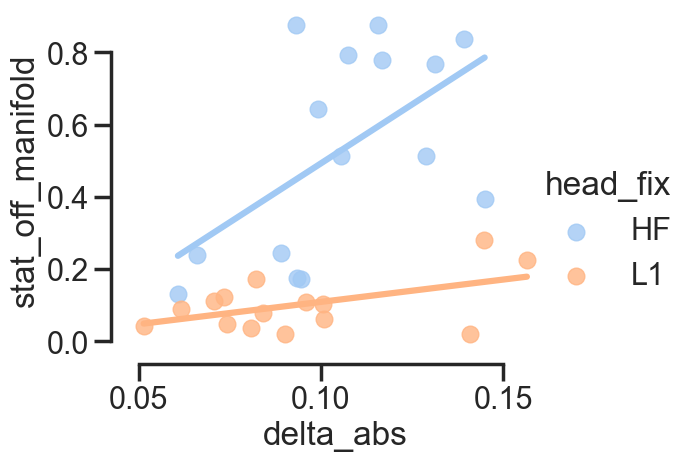

In [102]:
coi = ['L1', 'TS7-HF']
_inp_plot = df_pear[(df_pear.cond.isin(coi)) 
                    & (df_pear.stat_off_manifold > 0)
                    & (df_pear.rec_session.isin(vr_sess))
                   ]
x, y = 'delta_abs', 'stat_off_manifold'
sns.lmplot(data = _inp_plot, x = x, y = y,  aspect = 1.2, ci=None,
          hue = 'head_fix', hue_order = ['HF', 'L1'],
          )

a1 = _inp_plot[(_inp_plot.head_fix == 'L1')][x].values
a2 = _inp_plot[(_inp_plot.head_fix == 'L1')][y].values
b1 = _inp_plot[(_inp_plot.head_fix == 'HF')][x].values
b2 = _inp_plot[(_inp_plot.head_fix == 'HF')][y].values

print('L1', stats.pearsonr(a1, a2))
print('HF', stats.pearsonr(b1, b2))
sns.despine(offset=10, trim=True)

# plt.savefig(f'lmplot_{x}_{y}_{coi}.pdf', transparent = True)

In [103]:
df_tau_corr5.head()

,pair,tau,pval,rec_session,cond,head_fix,rec_id,hdc_pair,speed_thr,run,abstau
0,"(1, 4)",0.653044,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,all,0.653044
0,"(1, 4)",0.680417,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,stat,0.680417
0,"(1, 4)",0.506986,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,run,0.506986
0,"(1, 7)",-0.333650,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,all,0.333650
0,"(1, 7)",-0.367457,0.0,JA178_20220818,D1,D1,20220818_JA178_lADN_red_H2_R_D1,1_1,5,stat,0.367457


array(['JA178_20220819', 'JA178_20220823', 'JA178_20220907',
       'JA179_20220802', 'JA179_20220804', 'JA179_20220805',
       'JA180_20220809', 'JA180_20220810', 'JA180_20220811',
       'JA180_20220819', 'JA181_20220809', 'JA181_20220812',
       'MC022_20220627', 'MC022_20220629', 'MC038_20220829'], dtype=object)